# BackTrader 入门

在这个 Notebook 中我们会简单介绍 Backtrader 中的整体框架和重要编程概念，并且用一个简单双均线策略来进行回测的演示。Backtrader 是目前功能最完善的 Python 量化回测框架之一，是一个易懂、易上手的量化投资框架。

开始之前，请选择 conda_python3 内核。

## 准备工作
首先，输入以下命令安装 Backtrader 和 matplotlib 模块:

In [4]:
!pip install backtrader -i https://opentuna.cn/pypi/web/simple
# !pip uninstall matplotlib -y
!pip install matplotlib==3.2.2 -i https://opentuna.cn/pypi/web/simple
    
import backtrader as bt

Looking in indexes: https://opentuna.cn/pypi/web/simple
Looking in indexes: https://opentuna.cn/pypi/web/simple


## BackTrader 入门

接下来我们将尝试编写并运行一个Backtrader回测程序。BackTrader的回测程序主要包括以下几个组成部分：

- 数据加载（Data Feed）：将交易策略的数据加载到回测框架中。
- 交易策略（Strategy）：最核心的交易算法部分，需要设计交易决策，生成买卖信号。
- 回测框架设置和运行（Cerebro）：需要设置初始资金、佣金比例、数据馈送、交易策略、交易头寸大小等。随后运行Cerebro回测并打印出所有已执行的交易。
- 评估结果（Analyzers）:以图形和风险收益等指标对交易策略的回测结果进行评价。

### 一、数据加载

在 Backtrader 平台中，回测数据由 Lines 类进行表示。回测数据通常包含数个完整的时间序列，通常包括以下数据列：Open（开盘价）, High（最高价）, Low（最低价）, Close（收盘价）, Volume（成交量）, OpenInterest。Data Feeds（数据加载）、Indicators（技术指标）和Strategies（策略）都会生成 Lines，每个 Lines 类可以包含多个 line series 时间序列。在下面的示例中，我们将通过 DataFrame 作为数据源创建一个 Data Feed，并且创建一个名为 SMA（均线）的技术指标。

首先，我们定义一个用来从 Athena 中指向查询语句的函数：

In [5]:
!pip install awswrangler

import awswrangler as wr

s3_output = wr.athena.create_athena_bucket()


def execute_query(database, sql):
    
    query_execution_id = wr.athena.start_query_execution(database=database, sql=sql)
    response = wr.athena.get_query_execution(query_execution_id=query_execution_id)
    wr.athena.wait_query(query_execution_id=query_execution_id)
    OutputLocation = response['ResultConfiguration']['OutputLocation']
    
    return OutputLocation

在 Athena 中执行一个 SQL 查询获取某支股票（例如贵州茅台）从 2019 年至今的行情：

In [6]:
database = 'stock-data'
table = 'stock_day'
fields = '*'
ticker = '600519'
orderby = 'tradedate'
sort = 'ASC'

sql = f'''
SELECT {fields}
FROM "{database}"."{table}"
WHERE ticker='{ticker}'
AND tradedate>='2019-01-01'
ORDER BY {orderby}
{sort}
'''

output_location = execute_query(database, sql)
print(output_location)

s3://aws-athena-query-results-364198545638-us-east-1/00d7815e-8f93-4502-b66d-db8e7eacc892.csv


查询完成后，可以看到查询的结果储存在一个默认 S3 存储桶的 csv 文件中。这时我们可以通过 Data Wrangler 将这个 CSV 文件读取为一个 DataFrame：

In [7]:
df = wr.s3.read_csv(path=[output_location])
df.head()

,ticker,secid,tradedate,openprice,highestprice,lowestprice,closeprice,turnovervol,turnovervalue,accumadjfactor,isopen
0,600519,600519.SH,2019-01-02,609.98,612.00,595.01,598.98,6228649.0,3.754388e+09,7.211773,True
1,600519,600519.SH,2019-01-03,599.97,601.66,585.80,590.00,3097735.0,1.838179e+09,7.211773,True
2,600519,600519.SH,2019-01-04,587.28,607.67,582.02,602.00,3768347.0,2.258501e+09,7.211773,True
3,600519,600519.SH,2019-01-07,608.00,612.00,602.22,605.49,3475013.0,2.105981e+09,7.211773,True
4,600519,600519.SH,2019-01-08,605.50,612.00,600.28,604.79,2883813.0,1.750413e+09,7.211773,True


BackTrader 要求行情格式必须是 OHLC 格式的。这里可以对行情文件进行一些简单的数据转换和复权处理：

In [8]:
df['ticker'] = df['ticker'].apply(lambda x: str(x))
df['ticker'] = df['ticker'].apply(lambda x: '0'*(6-len(x)) + x)
df['openprice'] = df['openprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['closeprice'] = df['closeprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['highestprice'] = df['highestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['lowestprice'] = df['lowestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df = df[df['isopen'] == True]
df.drop('isopen', 1, inplace=True)
df.drop('accumadjfactor', 1, inplace=True)
df.set_index('tradedate', inplace=True)

df.rename(columns={'openprice': 'open'}, inplace=True)
df.rename(columns={'closeprice': 'close'}, inplace=True)
df.rename(columns={'highestprice': 'high'}, inplace=True)
df.rename(columns={'lowestprice': 'low'}, inplace=True)
df.rename(columns={'turnovervol': 'volume'}, inplace=True)
df['openinterest'] = 0 # A股回测中一般并不考虑利率，通常可以直接设为 0
df.head()

,ticker,secid,open,high,low,close,volume,turnovervalue,openinterest
tradedate,,,,,,,,,
2019-01-02,600519,600519.SH,588.598322,590.547514,574.153066,577.983905,6228649.0,3.754388e+09,0
2019-01-03,600519,600519.SH,578.939203,580.569963,565.265905,569.318682,3097735.0,1.838179e+09,0
2019-01-04,600519,600519.SH,566.694027,586.369294,561.618406,580.898045,3768347.0,2.258501e+09,0
2019-01-07,600519,600519.SH,586.687727,590.547514,581.110333,584.265710,3475013.0,2.105981e+09,0
2019-01-08,600519,600519.SH,584.275359,590.547514,579.238336,583.590247,2883813.0,1.750413e+09,0


可以将复权后的数据进行一些简单可视化：

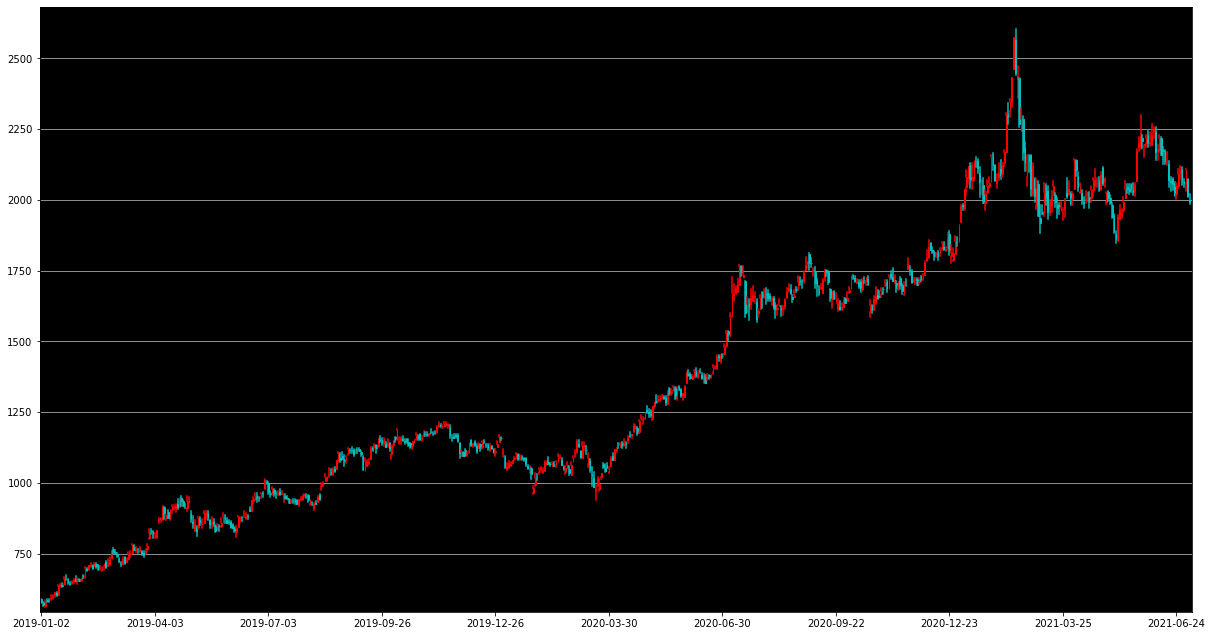

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as lines
import matplotlib.patches as patches


def plot_candle_stick(prices):

    n = len(prices)
    
    fig = plt.figure(figsize=(20, 12))

    ax = fig.add_axes([0.1, 0.15, 0.8, 0.7])
    ax.set_facecolor('black')
    ax.set_axisbelow(True)

    ax.grid(False, axis='x')
    ax.grid(True, axis='y')
    ax.set_xlim(-1, n)
    ax.set_ylim(min(prices['low']) * 0.97, max(prices['high']) * 1.03)
    ax.set_xticks(range(0, n, max(int(n / 10), 1)))
    ax.set_xticklabels([prices.index.tolist()[index] for index in ax.get_xticks()])

    for i in range(0, n):
        openPrice = prices['open'].iloc[i]
        closePrice = prices['close'].iloc[i]
        highPrice = prices['high'].iloc[i]
        lowPrice = prices['low'].iloc[i]
        if closePrice > openPrice:
            ax.add_patch(
                patches.Rectangle((i - 0.2, openPrice), 0.4, closePrice - openPrice, fill=False, color='r'))
            ax.plot([i, i], [lowPrice, openPrice], 'r')
            ax.plot([i, i], [closePrice, highPrice], 'r')
        else:
            ax.add_patch(patches.Rectangle((i - 0.2, openPrice), 0.4, closePrice - openPrice, color='c'))
            ax.plot([i, i], [lowPrice, highPrice], color='c')
            
    return fig

fig = plot_candle_stick(df)

### 二、交易策略

交易策略即交易执行所需的核心逻辑。在Backtrader中，交易策略由backtrader.Strategy类进行定义。交易策略中一般至少需要定义以下代码：

- 全局参数。全局参数是在策略中通过tuples或dict定义的值。在这个策略中我们只设定了一个maperiod（均线周期）值为15。
- 策略初始化。Python中类的constructor由init()来定义。Backtrader中的交易策略是一个backtrader.Strategy类。
- 策略核心逻辑。以下策略模块的核心在next()函数中进行定义。该模块包含了执行买卖交易指令的条件。通常来讲策略必须在每个周期开始时进行持仓检查、可用资金检查、指令成交状态检查等，因此必须包含一些if/else条件作为基础。以下的示例中只包含了一个15日均线的判断条件：如果股价突破15日均线则买入，跌破15日均线则卖出。
- 记录日志（可选）。通常来讲策略执行中需要记录持仓、可用资金、逐笔交易的手续费和收益等日志指标，以方便回测结束后进行分析。


In [10]:
from datetime import datetime
import backtrader as bt

class MyStrategy(bt.Strategy):
    ## 全局参数
    params=(('fastmaperiod', 10),
            ('slowmaperiod', 30),
            ('printlog', False),)

    ## 策略初始化
    def __init__(self):

        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # 添加移动均线指标。Backtrader 集成了 talib，可以自动算出一些常见的技术指标
        self.fastma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.fastmaperiod)
        self.slowma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.slowmaperiod)
        
    ## 策略核心逻辑
    def next(self):
        # 记录收盘价
#         self.log('收盘价：%.2f' % self.datas[0].close[0])
        if self.order: # 检查是否有指令等待执行
            return
        # 检查是否持仓   
        if not self.position: # 如果没有持仓
            # 快线上穿慢线，执行买入
            if self.fastma[0] > self.slowma[0]:
                self.log('买入委托：%.2f' % self.datas[0].close[0])
                #执行买入
                self.size = int(self.broker.cash / self.datas[0].close[0])
                self.order = self.buy(size=self.size)
        else: # 
            # 快线下穿慢线，执行卖出
            if self.fastma[0] < self.slowma[0]:
                self.log('卖出委托：%.2f' % self.datas[0].close[0])
                #执行卖出
                self.order = self.sell(size=self.size)

    ## 4、日志记录
    # 交易记录日志（可选，默认不输出结果）
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')

    # 记录交易执行情况（可选，默认不输出结果）
    def notify_order(self, order):
        # 如果 order 为 submitted/accepted，返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果 order 为 buy/sell executed，报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入：\n价格：%.2f,\
                交易金额：-%.2f,\
                手续费：%.2f' % (order.executed.price, order.executed.value, order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：%.2f,\
                交易金额：%.2f,\
                手续费：%.2f' % (order.executed.price, order.executed.price*self.size, order.executed.comm))
            self.bar_executed = len(self) 

        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None

    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    # 回测结束后输出结果（可省略，默认输出结果）
    def stop(self):
        self.log('(MA均线： %2d日  %2d日) 期末总资金 %.2f' %
                 (self.params.fastmaperiod, self.params.slowmaperiod, self.broker.getvalue()), doprint=True)

### 三、回测框架设置和运行

下面我们将定义一个主函数，用于对某股票（例如贵州茅台）在指定期间进行回测。

通常在回测的主程序中可以定义以下内容：
- 导入回测所用的数据集
- 导入回测所用的策略，并定义回测使用的参数
- 定义回测账户的初始金额和手续费等参数

In [11]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import pandas as pd
import os.path
import sys

import backtrader as bt

if __name__ == '__main__':
    # 创建 Cerebro 对象
    cerebro = bt.Cerebro()

    # 创建 Data Feed
    df.index = pd.to_datetime(df.index)
    start = df.index[0]
    end = df.index[-1]
    print(start, '-', end)
    data = bt.feeds.PandasData(dataname=df, fromdate=start, todate=end)
    # 将 Data Feed 添加至 Cerebro
    cerebro.adddata(data)

    # 添加策略 Cerebro
    cerebro.addstrategy(MyStrategy, fastmaperiod=10, slowmaperiod=30, printlog=True)
    
    # 设置初始资金
    cerebro.broker.setcash(100000.0)
    # 设置手续费为万二
    cerebro.broker.setcommission(commission=0.0002) 

    # 在开始时 print 初始账户价值
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # 运行回测流程
    cerebro.run()

    # 在结束时 print 最终账户价值
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

2019-01-02 00:00:00 - 2021-07-05 00:00:00
Starting Portfolio Value: 100000.00
2019-02-19,买入委托：705.14
2019-02-20,交易失败
2019-02-20,买入委托：696.69
2019-02-21,买入：
价格：694.76,                交易金额：-99350.93,                手续费：19.87
2019-05-15,卖出委托：894.51
2019-05-16,卖出:
价格：886.79,                交易金额：126810.43,                手续费：25.36
2019-05-16,策略收益：
毛收益 27459.49, 净收益 27414.26
2019-06-18,买入委托：884.86
2019-06-19,交易失败
2019-06-19,买入委托：899.34
2019-06-20,买入：
价格：899.81,                交易金额：-126873.63,                手续费：25.37
2019-07-24,卖出委托：926.71
2019-07-25,卖出:
价格：926.33,                交易金额：130612.39,                手续费：26.12
2019-07-25,策略收益：
毛收益 3738.76, 净收益 3687.26
2019-08-14,买入委托：1021.67
2019-08-15,买入：
价格：1006.66,                交易金额：-128851.95,                手续费：25.77
2019-12-02,卖出委托：1109.48
2019-12-03,卖出:
价格：1109.48,                交易金额：142012.90,                手续费：28.40
2019-12-03,策略收益：
毛收益 13160.95, 净收益 13106.77
2020-02-20,买入委托：1094.79
2020-02-21,买入：
价格：1088.38,                交易金额：-142578

### 四、结果的可视化

Backtrader 提供了画图功能可以将回测结果进行简单的可视化：

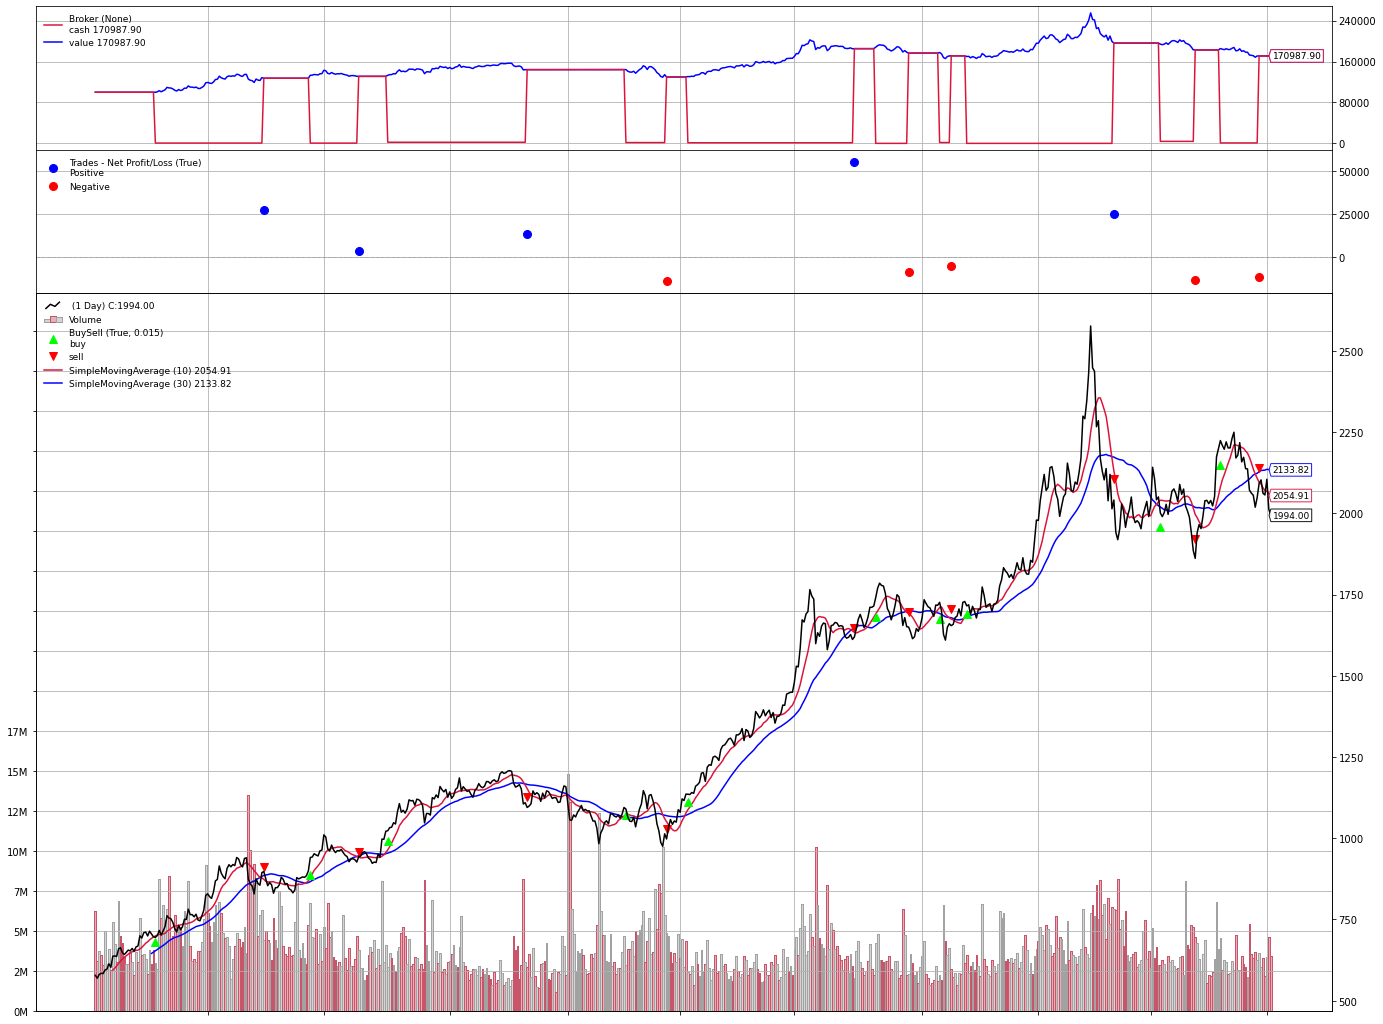

[[<Figure size 1440x1080 with 4 Axes>]]

In [19]:
%matplotlib inline
plt.rcParams['figure.figsize']=[20,15]
cerebro.plot(iplot=False)